In [22]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

PATH = "data/"


# Normailze the data over x,y and z

In [23]:
def compute_x_y_z_mean_and_std(array):
    """Returns list of means and stds for each channel of the array."""
    means = []
    stds = []
    for i in range(3):
        channel = array[:,:,i]
        mean = np.nanmean(channel)
        std = np.nanstd(channel)
        means.append(mean)
        stds.append(std)
    return means, stds


## Compute the dataset mean and std

In [24]:
general_mean = np.empty((1,3))
general_std = np.empty((1,3))

general_array = np.empty((75, 20, 3))

for folder in os.listdir(PATH):
    for file in os.listdir(PATH+folder):
        array = np.load(PATH+folder+"/"+file, allow_pickle=True)
        array = np.clip(array, -10, 10)
        # print(array.shape, general_array.shape)
        general_array = np.vstack((general_array, array))
        # print(folder, file, means, stds)

dataset_mean, dataset_std = compute_x_y_z_mean_and_std(general_array)
np.save("dataset_mean.npy", np.array(dataset_mean))
np.save("dataset_std.npy", np.array(dataset_std))


In [25]:
print(dataset_mean)
print(dataset_std)

[0.5103460465757472, 1.0729256891320302e+155, 2.8706499595453944e+168]
[0.3269020350888011, inf, inf]


# Neural Net

## Dataloader

In [26]:
for folder in os.listdir(PATH):
    print(folder)

stay
come
lie down
sit


In [27]:
# Define the dataset class
class CustomDataset(Dataset):
    def __init__(self, data_folder, dataset_mean, dataset_std):
        self.dataset = []
        self.labels = []
        label_dict = {"come":0,"lie down":1,"sit":2,"stay":3}
        
        for folder in os.listdir(data_folder):
            for file in os.listdir(data_folder + folder):
                data = np.load(os.path.join(data_folder, folder, file))
                data = np.nan_to_num(data)
                data = np.clip(data, -10, 10)
                # normalize data
                data[:,:,0] = (data[:,:,0] - dataset_mean[0])/dataset_std[0]
                data[:,:,1] = (data[:,:,1] - dataset_mean[1])/dataset_std[1]
                data[:,:,2] = (data[:,:,2] - dataset_mean[2])/dataset_std[2]
                self.dataset.append(data)
                self.labels.append(label_dict[folder])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        data = self.dataset[index]
        data = np.transpose(data, (2, 0, 1))
        label = self.labels[index]

        return torch.tensor(data).float(), torch.tensor(label)


## Model

In [28]:
class ConvNet(nn.Module):
    def __init__(self, n_input_channels=3, n_output=4):
        super().__init__()
    
        # input = 75x20x3
        self.conv1 = nn.Conv2d(n_input_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        # input = 37x10x32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # input = 18x5x64
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # input = 9x2x128
        self.fc1 = nn.Linear(128*9*2, 1024)
        self.fc2 = nn.Linear(1024, n_output)

    
    def forward(self, x):
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2) #maxpool of kernel size 2 to reduce the size of the images by a factor 2
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 128*9*2) #flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x
    
    def predict(self, x):
        logits = self.forward(x)
        return F.softmax(logits)

In [46]:
# Set the necessary hyperparameters
batch_size = 8
# learning_rate = 0.001
num_epochs = 20
num_classes = 4

# Set the path to your data folder
data_folder = PATH  # Replace with the actual path to your data folder

# Create an instance of the dataset
dataset = CustomDataset(data_folder, dataset_mean, dataset_std)

# Creating data indices for training and validation splits:
validation_split = .2
shuffle_dataset = True
random_seed= 42

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)


# Specify the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Create an instance of the CNN model and move it to the device
model = ConvNet().to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.00001)

cuda


In [47]:
for data, labels in train_loader:
    print(data.shape)
    print(labels.shape)
    break

torch.Size([8, 3, 75, 20])
torch.Size([8])


In [48]:
torch.cuda.get_device_properties(device)

_CudaDeviceProperties(name='NVIDIA GeForce RTX 3050 Laptop GPU', major=8, minor=6, total_memory=3913MB, multi_processor_count=16)

In [49]:
# Training loop
model.train()
total_step = len(train_loader)

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    num_correct = 0
    running_epoch_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):

        inputs = inputs.to(device)
        labels = labels.to(device)

        # print(inputs, labels)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred = outputs.argmax(dim = -1)

        num_correct += (y_pred == labels).sum().item()
        running_epoch_loss += loss.item()

    epoch_loss = running_epoch_loss / (len(train_loader))
    epoch_acc = num_correct / (len(train_loader.dataset)*(1-validation_split))

    print(f'Training => Loss: {epoch_loss:.4f} | Train Accuracy: {epoch_acc:.4f}')

Epoch 1/20
Training => Loss: 1.2698 | Train Accuracy: 0.4761
Epoch 2/20
Training => Loss: 0.8194 | Train Accuracy: 0.7021
Epoch 3/20
Training => Loss: 0.6683 | Train Accuracy: 0.7766
Epoch 4/20
Training => Loss: 0.5013 | Train Accuracy: 0.8404
Epoch 5/20
Training => Loss: 0.4113 | Train Accuracy: 0.8856
Epoch 6/20
Training => Loss: 0.3418 | Train Accuracy: 0.8910
Epoch 7/20
Training => Loss: 0.3159 | Train Accuracy: 0.9149
Epoch 8/20
Training => Loss: 0.2676 | Train Accuracy: 0.9362
Epoch 9/20
Training => Loss: 0.2397 | Train Accuracy: 0.9282
Epoch 10/20
Training => Loss: 0.2097 | Train Accuracy: 0.9441
Epoch 11/20
Training => Loss: 0.2007 | Train Accuracy: 0.9335
Epoch 12/20
Training => Loss: 0.1396 | Train Accuracy: 0.9628
Epoch 13/20
Training => Loss: 0.1503 | Train Accuracy: 0.9681
Epoch 14/20
Training => Loss: 0.1150 | Train Accuracy: 0.9601
Epoch 15/20
Training => Loss: 0.1001 | Train Accuracy: 0.9734
Epoch 16/20
Training => Loss: 0.0828 | Train Accuracy: 0.9814
Epoch 17/20
Train

In [50]:
# Evaluation
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    gt = []
    pred = []
    for inputs , labels in validation_loader:
        # Move data to the device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Get predicted labels
        y_pred = outputs.argmax(dim = -1)

        gt.extend(labels.tolist())
        pred.extend(y_pred.tolist())

        # Update total and correct predictions
        total += labels.size(0)
        correct += (y_pred == labels).sum().item()

    # Print accuracy
    print('Test Accuracy: {:.2f}%'.format(100 * correct / total))

# Save the trained model
torch.save(model.state_dict(), 'trained_model.pth')

Test Accuracy: 84.04%


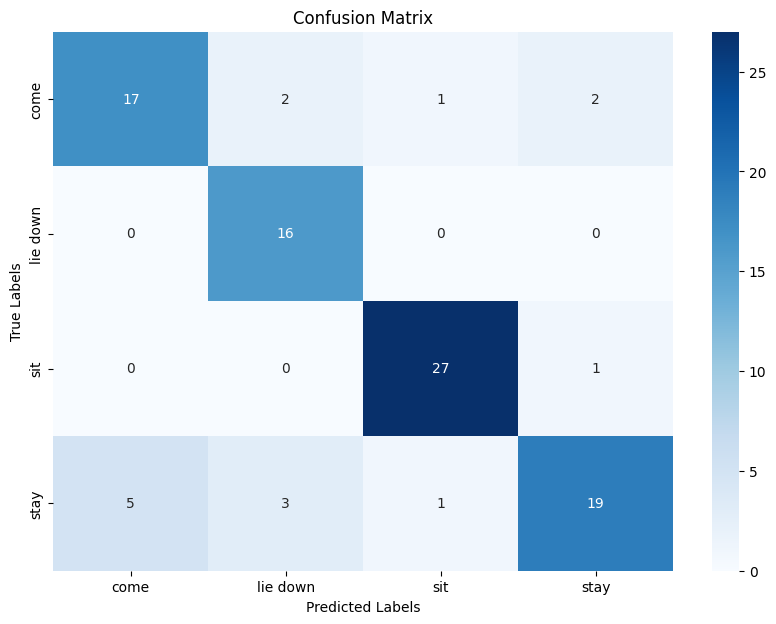

In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

label_dict = {"come":0,"lie down":1,"sit":2,"stay":3}

def plot_confusion_matrix(true_labels, predicted_labels, classes):
    cm = confusion_matrix(true_labels, predicted_labels)
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


plot_confusion_matrix(gt, pred, list(label_dict.keys()))